### Author: Helen Cai
### April 2025
The purpose of this notebook is to create a diffusion model that will be used in our final project.

The gist is that we would like to perform conditional diffusion to generate new points with a certain desired property; e.g., new latent space embeddings (in 32x1 space) conditioned on a numeric target value.  The size of the target property is a float of size 1. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Linear
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import tqdm


from diffusers import DDPMScheduler, UNet2DModel


# NetworkX is a Python package used to create, manipulate, and mine graphs
import networkx as nx

# further libraries for working with graphs
import torch_geometric
from torch_geometric.nn import GCNConv, pool
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader

# For visualization
import phate

# Graph scattering functionality
from LEGS_module import *

# Home-grown functions
from utils import *

## Hyperparameters

In [2]:
batch_size = 1
epochs = 5
learning_rate = 1e-4

## 0. Import data

In [3]:
hidden_values = torch.load("hidden_values_from_insecticides.pt", weights_only=False)
insecticides = torch.load("./data/insecticides_graphs_small.pt", weights_only=False)

# note that logP values are in the y slot of the data

In [4]:
# Obtain the logP values
# note that we don't actually need the graphs for training the diffusion process
y_values = []

for i in range(len(insecticides)):
    graph = insecticides[i]
    graph.hidden_values = hidden_values[i]
    y_values.append(graph.y)

Calculating PHATE...
  Running PHATE on 625 observations and 32 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.07 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.09 seconds.
  Calculating optimal t...


/home/hsc26/.conda/envs/cpsc_452/lib/python3.12/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 79 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Automatically selected t = 17
  Calculated optimal t in 65.69 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.23 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.98 seconds.
Calculated PHATE in 68.04 seconds.


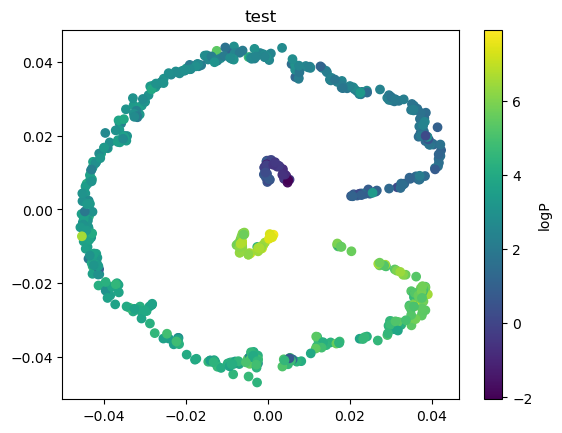

In [5]:
# apply PHATE with hidden values
phate_operator = phate.PHATE()
Y_phate = phate_operator.fit_transform(hidden_values)
plt.scatter(x = Y_phate[:,0], 
            y = Y_phate[:,1],
            c = y_values, cmap = 'viridis')
plt.colorbar(label="logP")
plt.title("test")
plt.show()

In [6]:
# Create dataloaders 
# split into training and test
train_dataset, test_dataset = train_test_split(insecticides, test_size=0.2, random_state=2025)

all_data = DataLoader(insecticides, batch_size=1, shuffle = False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 1. Training a conditional diffusion model

Tutorial for making a class-conditioned diffusion model taken from:
https://huggingface.co/learn/diffusion-course/en/unit2/3

In [31]:
class DiffuseNet(nn.Module):
    def __init__(
        self, 
        input_size=32,  # dimension of the latent space
        class_emb_size=1):
        
        super().__init__()

        # embedding for the class
        self.class_embedding = nn.Linear(class_emb_size, 1)

        # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
        self.model = UNet2DModel(
            sample_size=32,  # target size = size of latent space embedding
            in_channels=1 + class_emb_size,  # Additional input channels for class cond.
            out_channels=1,  # the number of output channels
            layers_per_block=2,  # how many ResNet layers to use per UNet block
            block_out_channels=(32, 64, 64),
            down_block_types=(
                "DownBlock2D",  # a regular ResNet downsampling block
                "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
                "UpBlock2D",  # a regular ResNet upsampling block
            ),
        )

    # Our forward method now takes the property value as an additional argument
    def forward(self, x, t, property_label):
        bs, ch, w, h = x.shape
        
        # class conditioning in right shape to add as additional input channels
        property_label = self.class_embedding(property_label.view(bs, -1))
        property_label = property_label.unsqueeze(-1).unsqueeze(-1)
        property_label = property_label.view(bs, 1, w, h)
        # Net input is now x and class cond concatenated together along dimension 1
        net_input = torch.cat((x, property_label), 1)  
        
        # Feed this to the UNet alongside the timestep and return the prediction
        return self.model(net_input, t).sample  

In [26]:
def train_diffusion_epoch(model, optimizer, train_loader):
    """Train the model for one epoch.
    Args:
        model: the model
        optimizer: the optimizer
        train_loader: contains all information needed for training, including graphs and their latent space representations.
    Returns:
        train_loss: the loss of the epoch
    """

    optimizer.zero_grad()
    loss_epoch = 0

    # Our loss function
    loss_fn = nn.MSELoss()
    
    for data in train_loader:
        batch_size = data.num_graphs 
        
        # Get some data and prepare the corrupted version
        x = data.hidden_values.view(1, 1, 32, 1)
        y = data.y
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long()
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        pred = model(noisy_x, timesteps, y)  # Note that we pass in the labels y

        # Calculate the loss
        loss = loss_fn(pred, noise)  # How close is the output to the noise

        # Backprop and update the params:
        loss.backward()
        loss_epoch += loss.detach().numpy * batch_size
        
        optimizer.step()

    # calculate training loss for the epoch
    loss_epoch = loss_epoch / len(train_loader.dataset)

    return loss_epoch


In [16]:
def train_diffusion(model, train_loader, test_loader, optimizer, epochs=5):
    """Train the model.
    Args:
        model: the model
        loss_fn: the loss function
        train_loader: the training data loader
        test_loader: the testing data loader
        optimizer: the optimizer
        epochs: the number of epochs to train
    Returns:
        train_losses: the training losses
        test_losses: the testing losses
    """
    train_losses = []
        
    loop = tqdm.tqdm(range(1, epochs + 1))

    for epoch in loop:

        # train the model for one epoch
        train_loss_epoch = train_decoder_epoch(model, optimizer, train_loader)
        
        # put into our storage vectors
        train_losses.append(train_loss_epoch)
        
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(train_loss=train_loss_epoch)
    
    return train_losses

In [32]:
# Define the network
diffuser = DiffuseNet()
 
# Create a scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

optimizer = torch.optim.Adam(diffuser.parameters(), lr=learning_rate)

train_diffusion_epoch(diffuser, optimizer, train_loader)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 2 but got size 1 for tensor number 1 in the list.

In [ ]:
plot_metrics(train_losses, train_losses, 
             xlabel="Epoch", ylabel="Loss", title="MSE Loss", 
             fname="mse_loss.png", subdir="./training-figs/diffusion/")

## 2. Generation: conditional sampling in the latent space

We want to be able to walk around the latent space to get new molecules with a certain property, e.g. with logP < 2.

In [13]:
# Prepare random x to start from, plus some desired labels y
x = torch.randn(80, 1, 28, 28)
y = torch.tensor([[i] * 2 for i in range(10)]).flatten()

# Sampling loop
for i, t in tqdm.tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = diffuser(x, t, y)  # Again, note that we pass in our labels y

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach(), nrow=8)[0], cmap="Greys")

0it [00:00, ?it/s]


RuntimeError: shape '[80, 1, 1, 1]' is invalid for input of size 20

## 3. Export latent space points to be decoded by the decoder. 